In [1]:
# Import all required Library

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import keras
from tensorflow.keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D , Dropout
from keras.preprocessing import image
import cv2

import warnings
warnings.filterwarnings('ignore')

2024-10-10 11:26:39.073804: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 11:26:39.159071: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 11:26:39.160128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 11:26:40.839719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
labels=pd.read_csv('labels.csv')
train_path='/home/hitech/Deep_Learning /Classification Project/MultiClass Image Classification/train'
test_path='/home/hitech/Deep_Learning /Classification Project/MultiClass Image Classification/test'

In [3]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [63]:
len(labels['breed'].unique())

120

In [4]:
def to_jpg(path):
    return path+'.jpg'

labels['id']=labels['id'].apply(to_jpg)

In [5]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [6]:
gen=ImageDataGenerator(
    rescale=1./255.0,
    horizontal_flip=True,
    validation_split=0.2
)

In [7]:
# Sobel->class of cv2 (read about it also)

In [10]:
training_generator=gen.flow_from_dataframe(
    labels,
    directory=train_path,
    x_col='id',
    y_col='breed',
    subset='training',
    color_mode='rgb',
    target_size=(331,331),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 8178 validated image filenames belonging to 120 classes.


In [12]:
validation_generator=gen.flow_from_dataframe(
    labels,
    directory=train_path,
    x_col='id',
    y_col='breed',
    subset='validation',
    color_mode='rgb',
    target_size=(331,331),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 2044 validated image filenames belonging to 120 classes.


In [13]:
x,y=next(training_generator)
x.shape

(32, 331, 331, 3)

In [35]:
a=training_generator.class_indices
class_names=list(a.keys())

def plot_images(img,label):
    plt.figure(figsize=(15,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(label[i])])
        plt.axis('off')

# plot_images(x,y)

In [36]:
# base_model
base_model=tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(331,331,3)
)

2024-10-10 12:03:32.900197: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


219055592/219055592 [==============================] - 16s 0us/step


In [37]:
base_model.trainable=False
input_tensor=tf.keras.Input(shape=(331,331,3))
output_tesnor=base_model(input_tensor)

In [42]:
# Now build final model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  # This reduces dimensions to (None, channels)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax')
])


In [43]:
# compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 9, 9, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_2  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_203 (B  (None, 1536)              6144      
 atchNormalization)                                              
                                                                 
 dense_8 (Dense)             (None, 512)               786944    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                      

In [45]:
early=tf.keras.callbacks.EarlyStopping(patience=10,min_delta=0.001,restore_best_weights=True)

In [46]:
# training the model
batch_size=32
step_size_train=training_generator.n//training_generator.batch_size
step_size_val=validation_generator.n//validation_generator.batch_size

step_size_train,step_size_val

(63, 63)

In [47]:
history=model.fit(training_generator,steps_per_epoch=step_size_train,validation_data=validation_generator,
                 validation_steps=step_size_val,epochs=30,callbacks=[early])

Epoch 1/30
63/63 [==============================] - 963s 15s/step - loss: 2.3486 - accuracy: 0.5273 - val_loss: 2.2074 - val_accuracy: 0.8710
Epoch 2/30
63/63 [==============================] - 977s 16s/step - loss: 0.6020 - accuracy: 0.8519 - val_loss: 1.2356 - val_accuracy: 0.9231
Epoch 3/30
63/63 [==============================] - 864s 14s/step - loss: 0.4678 - accuracy: 0.8782 - val_loss: 0.5658 - val_accuracy: 0.9256
Epoch 4/30
63/63 [==============================] - 862s 14s/step - loss: 0.4498 - accuracy: 0.8827 - val_loss: 0.3173 - val_accuracy: 0.9301
Epoch 5/30
63/63 [==============================] - 863s 14s/step - loss: 0.3479 - accuracy: 0.8941 - val_loss: 0.1801 - val_accuracy: 0.9499
Epoch 6/30
63/63 [==============================] - 861s 14s/step - loss: 0.3312 - accuracy: 0.9001 - val_loss: 0.1716 - val_accuracy: 0.9474
Epoch 7/30
63/63 [==============================] - 860s 14s/step - loss: 0.3000 - accuracy: 0.9130 - val_loss: 0.1435 - val_accuracy: 0.9514
Epoch 

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9572564363479614\nValidation Accuracy: 0.985615074634552')

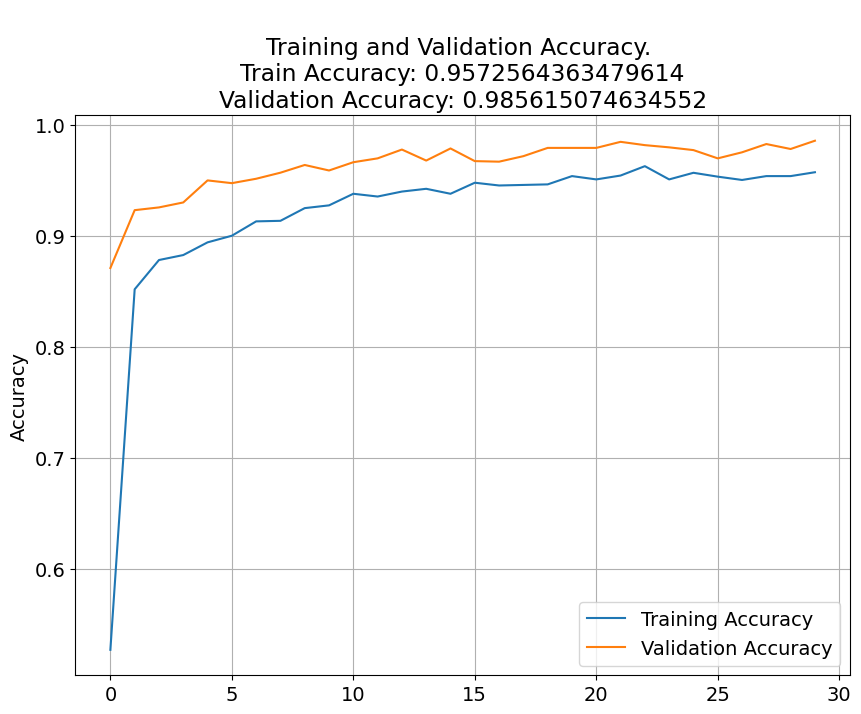

In [50]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

# pots results accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

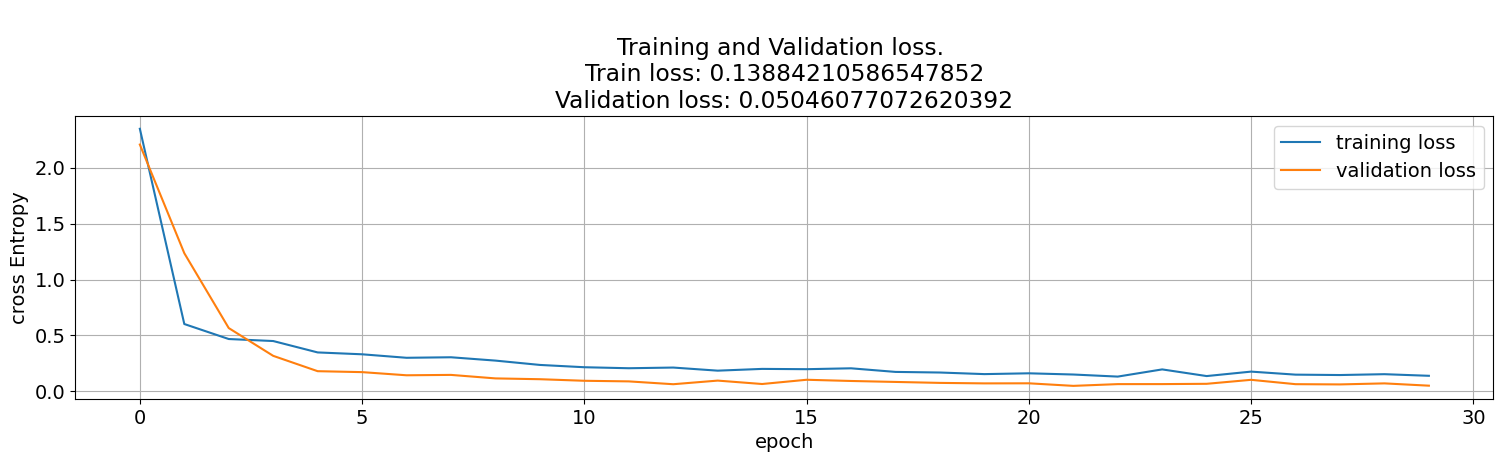

In [51]:
plt.subplot(2,1,2)
plt.plot(loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.legend(loc='upper right')
plt.ylabel('cross Entropy')
plt.title(f'\nTraining and Validation loss. \nTrain loss: {str(loss[-1])}\nValidation loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [52]:
accuracy_score=model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 

print("Loss: ",accuracy_score[0])

64/64 [==============================] - 442s 7s/step - loss: 0.0467 - accuracy: 0.9868
[0.046734459698200226, 0.9867905974388123]
Accuracy: 98.6791%
Loss:  0.046734459698200226


In [54]:
model.save('dog_image_classification.h5')

In [55]:
img_path=test_path+'/'+'0a01f3b0c6d250c08785716c562e2d4d.jpg'
img=tf.keras.preprocessing.image.load_img(img_path)
img=tf.keras.preprocessing.image.img_to_array(img)
img=tf.keras.preprocessing.image.smart_resize(img,(331,331))
img=tf.reshape(img,(-1,331,331,3))
prediction=model.predict(img)

1/1 [==============================] - 4s 4s/step


In [57]:
print(np.argmax(prediction)) # this is gives the id of breed of dog

102
